In [36]:
import pandas as pd

In [37]:
analytics_df = pd.read_csv('../output/vulnerabilities_with_cwes.csv')

In [38]:
columns_to_drop = [
    'vulnerabilityName',
    'notes',
    'shortDescription',
    'requiredAction',
    'CWE_Description'
]

# Drop columns if they exist
existing_columns = [
    col for col in columns_to_drop
    if col in analytics_df.columns
]    
if existing_columns:
    analytics_df.drop(columns=existing_columns, inplace=True)

In [41]:
desired_columns = [
        'cveID',
        'vendorProject',
        'product',
        'cwes',
        'CWE_Name',
        'CWE_Status',
        'dateAdded',
        'dueDate',
        'attack_vector',
        'CWE_Likelihood',
        'attack_complexity',
        'cvss_score',
        'severity',
        'knownRansomwareCampaignUse'
    ]

    # Reorder columns (only include columns that exist in the DataFrame)
existing_columns = [col for col in desired_columns if col in analytics_df.columns]
analytics_df = analytics_df[existing_columns]

In [42]:
def map_likelihood_to_probability(likelihood):
    likelihood_map = {
        'HIGH': 0.9,
        'MEDIUM': 0.6,
        'LOW': 0.3,
        'None': 0.1
    }
    return likelihood_map.get(likelihood.upper() if isinstance(likelihood, str) else 'None', 0.1)

In [43]:
def map_attack_complexity_to_probability(complexity):
    complexity_map = {
        'LOW': 0.9,    # Easy to exploit
        'MEDIUM': 0.6, # Moderate difficulty
        'HIGH': 0.3,   # Hard to exploit
        'None': 0.1    # Default value for missing/none
    }
    return complexity_map.get(complexity.upper() if isinstance(complexity, str) else 'None', 0.1)


In [44]:
def calculate_ransomware_probability(df) -> pd.DataFrame:
    result_df = df.copy()
    
    result_df['likelihood_prob'] = result_df['CWE_Likelihood'].apply(map_likelihood_to_probability)
    result_df['complexity_prob'] = result_df['attack_complexity'].apply(map_attack_complexity_to_probability)
    
    LIKELIHOOD_WEIGHT = 0.6
    COMPLEXITY_WEIGHT = 0.4
    
    result_df['ransomware_probability'] = (
        (result_df['likelihood_prob'] * LIKELIHOOD_WEIGHT) + 
        (result_df['complexity_prob'] * COMPLEXITY_WEIGHT)
    )

    result_df['ransomware_probability'] = result_df['ransomware_probability'].round(3)

    def categorize_risk(prob):
        if prob >= 0.7:
            return 'High'
        elif prob >= 0.4:
            return 'Medium'
        else:
            return 'Low'
    
    result_df['risk_category'] = result_df['ransomware_probability'].apply(categorize_risk)

    return result_df

In [45]:
analytics_df = calculate_ransomware_probability(analytics_df)

In [50]:
print(analytics_df['ransomware_probability'].describe())
NEW_CSV_NAME = "../output/ransomware_probabilities.csv"
analytics_df.to_csv(NEW_CSV_NAME, index=False)
print("Enhanced data saved to 'ransomware_probabilities.csv'")

count    1202.000000
mean        0.654908
std         0.246024
min         0.100000
25%         0.420000
50%         0.720000
75%         0.900000
max         0.900000
Name: ransomware_probability, dtype: float64
Enhanced data saved to 'ransomware_probabilities.csv'


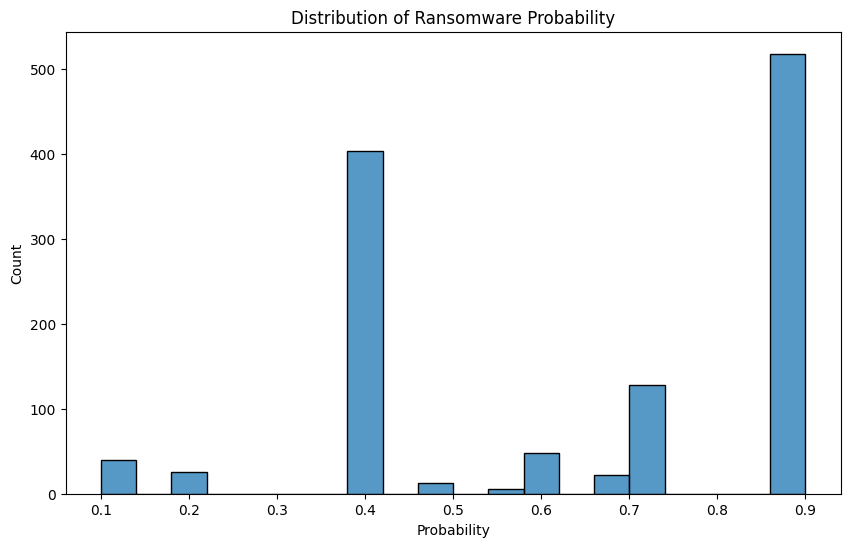

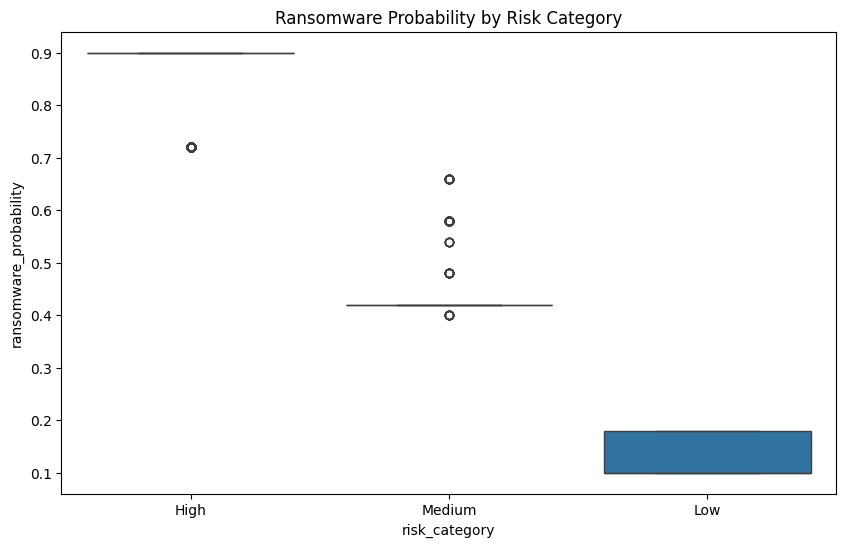

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=analytics_df, x='ransomware_probability', bins=20)
plt.title('Distribution of Ransomware Probability')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()

# Create a box plot to show probability distribution by risk category
plt.figure(figsize=(10, 6))
sns.boxplot(data=analytics_df, x='risk_category', y='ransomware_probability')
plt.title('Ransomware Probability by Risk Category')
plt.show()